In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("/kaggle/input/oranges-vs-grapefruit/citrus.csv")
data = pd.DataFrame(data)
data

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,grapefruit,15.35,253.89,149,77,20
9996,grapefruit,15.41,254.67,148,68,7
9997,grapefruit,15.59,256.50,168,82,20
9998,grapefruit,15.92,260.14,142,72,11


In [3]:
# the RGB values are stored in separate columns: 'red', 'green', 'blue'

# function to convert RGB values to hex color code
# def rgb_to_hex(row):
#     red = row['red']
#     green = row['green']
#     blue = row['blue']
#     hex_color = "#{:02x}{:02x}{:02x}".format(red, green, blue)
#     return hex_color

# # Apply the function to create a new column 'hex_color' in the DataFrame
# data['hex_color'] = data.apply(rgb_to_hex, axis=1)
data


,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,grapefruit,15.35,253.89,149,77,20
9996,grapefruit,15.41,254.67,148,68,7
9997,grapefruit,15.59,256.50,168,82,20
9998,grapefruit,15.92,260.14,142,72,11


In [4]:
data.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


/tmp/ipykernel_23/3983234944.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr(method = 'pearson')


<Axes: >

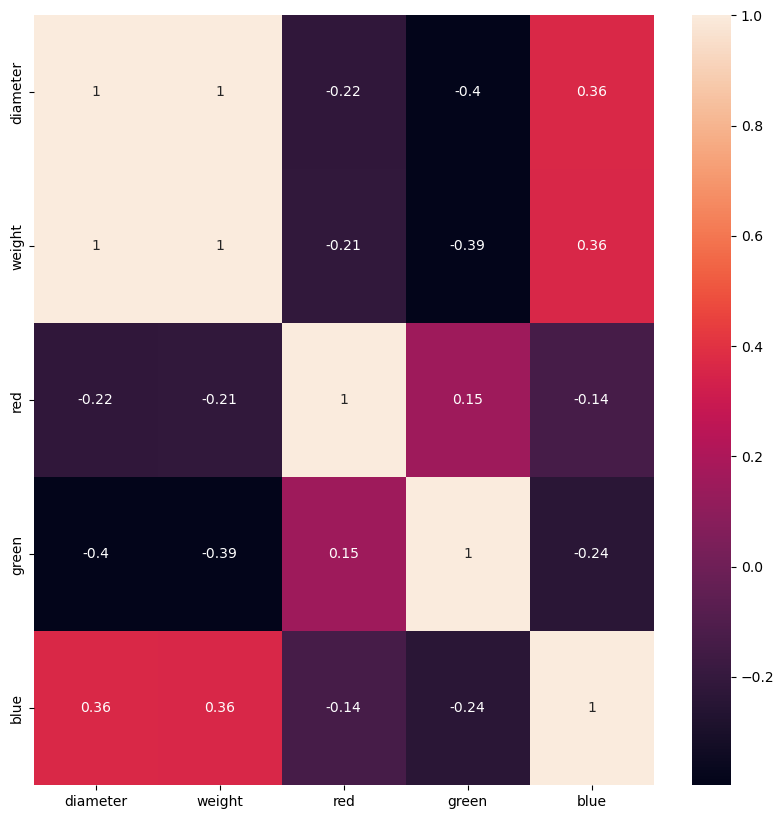

In [6]:
# Seprating Related and Unrelated Columns
cor = data.corr(method = 'pearson')
plt.figure(figsize = (10,10))
sns.heatmap(cor, annot=True)

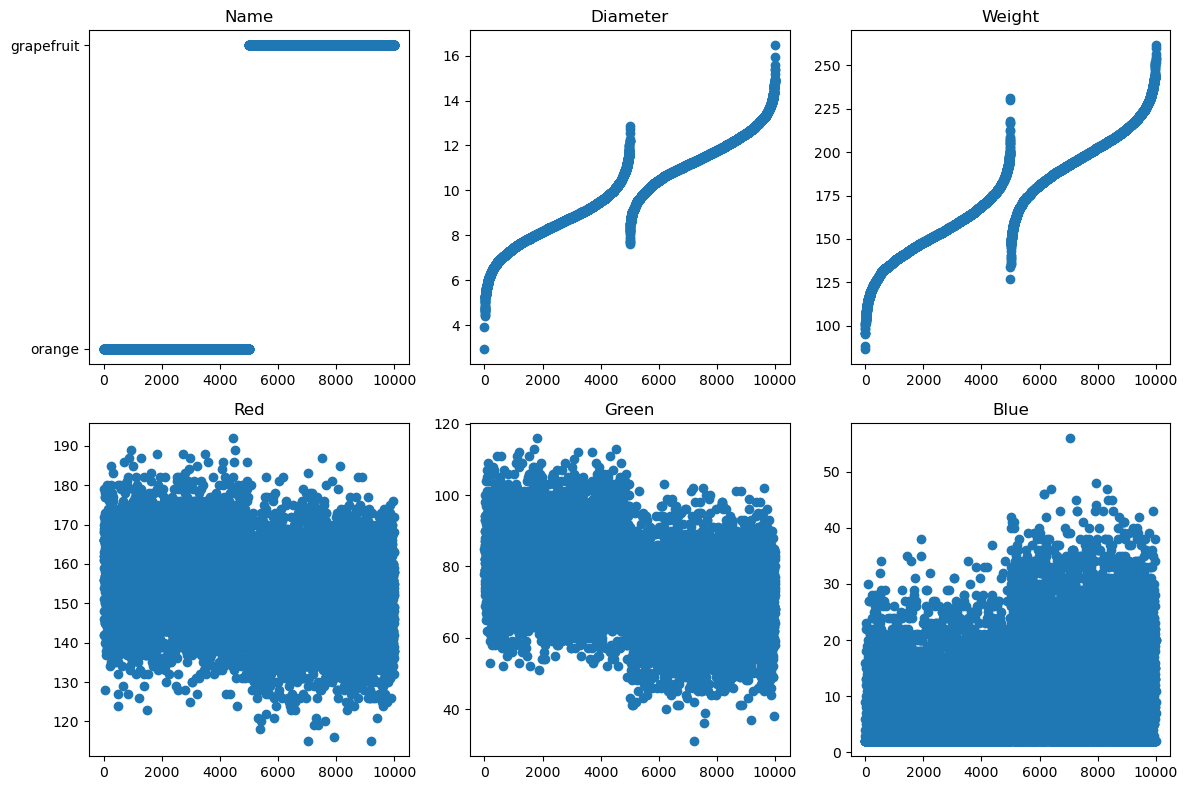

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot on the first subplot
axs[0, 0].scatter(data.index, data['name'])
axs[0, 0].set_title('Name')

# Plot on the second subplot
axs[0, 1].scatter(data.index, data['diameter'])
axs[0, 1].set_title('Diameter')

# Plot on the third subplot
axs[0, 2].scatter(data.index, data['weight'])
axs[0, 2].set_title('Weight')

# Plot on the fourth subplot
axs[1, 0].scatter(data.index, data['red'])
axs[1, 0].set_title('Red')

# Plot on the fifth subplot
axs[1, 1].scatter(data.index, data['green'])
axs[1, 1].set_title('Green')

# Plot on the sixth subplot
axs[1, 2].scatter(data.index, data['blue'])
axs[1, 2].set_title('Blue')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

Update my dataset and remove outliers
outliers could be :

  * Empty cells

  * Data in wrong format

  * Wrong data

  * Duplicates


Calculate Mean,STD,Variance for all given columns

In [8]:
# Create a dictionary to store the statistical measures
stat_dict = {
    "diameter": [],
    "weight": [],
    "red": [],
    "green": [],
    "blue": []
}

# Iterate over the columns in the dataset
for label in data.columns:
    # Convert column values to numeric type, non-numeric values will be set as NaN
    values = pd.to_numeric(data[label], errors='coerce')

    # Check if all values in the column are not null (i.e., numeric)
    if values.notnull().all():
        # Calculate statistical measures and append them to the respective list in stat_dict
        stat_dict[label].extend( [np.mean(values) , np.var(values) ,np.std(values)])

print(stat_dict)

{'diameter': [9.975685, 3.7937155107750002, 1.9477462644746621], 'weight': [175.050792, 853.262576972736, 29.210658619290598], 'red': [153.8478, 108.83563515999997, 10.43243189098304], 'green': [76.0106, 137.07368764, 11.707847267538128], 'blue': [11.3632, 82.09848576, 9.060821472692197]}


<Axes: xlabel='blue', ylabel='Count'>

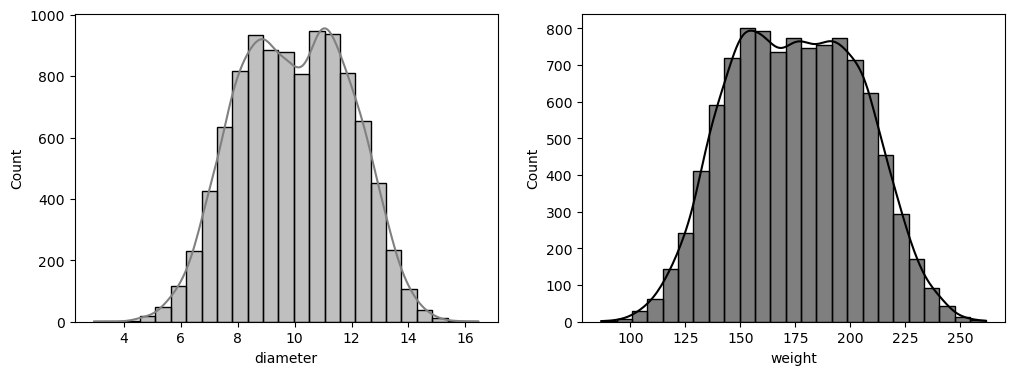

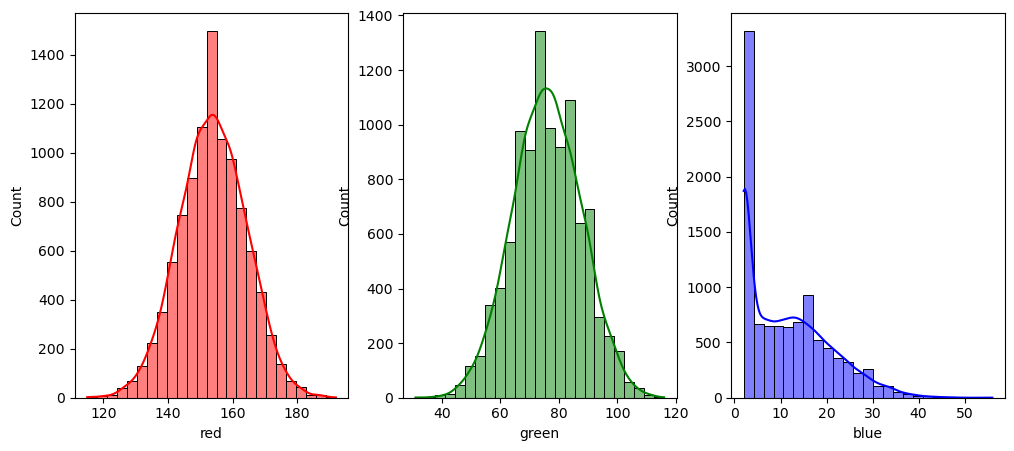

In [9]:
# distribution of data before standarization
import seaborn as sns

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs2 = plt.subplots(1, 3, figsize=(12, 5))

sns.histplot(data, x="diameter", kde=True, color='grey', ax=axs[0] , bins = 25)
sns.histplot(data, x="weight", kde=True, color='black', ax=axs[1], bins = 25)
sns.histplot(data, x="red", kde=True, color='r', ax=axs2[0], bins = 25)
sns.histplot(data, x="green", kde=True, color='green', ax=axs2[1], bins = 25)
sns.histplot(data, x="blue", kde=True, color='b', ax=axs2[2], bins = 25)

In [10]:
# First, we define our limits
limits_dict = {}

for label, stats in stat_dict.items():
    if len(stats) >= 3:
        lower_limit = stats[0] - (3 * stats[2])
        upper_limit = stats[0] + (3 * stats[2])
        limits_dict[label] = [lower_limit, upper_limit]
    else:
        print(f"Insufficient data for {label}")

print(limits_dict)

# Filter the data DataFrame based on the defined limits
for label in data.columns:
    for x in data.index:
        if label in limits_dict and len(limits_dict[label]) >= 2:
            if data.loc[x, label] < limits_dict[label][0] or data.loc[x, label] > limits_dict[label][1]:
                data.drop(x, inplace=True)

print(data)


{'diameter': [4.132446206576014, 15.818923793423988], 'weight': [87.41881614212821, 262.6827678578718], 'red': [122.55050432705089, 185.14509567294914], 'green': [40.88705819738561, 111.13414180261438], 'blue': [-15.81926441807659, 38.54566441807659]}
            name  diameter  weight  red  green  blue
2         orange      4.42   95.17  156     81     2
3         orange      4.47   95.60  163     81     4
4         orange      4.48   95.76  161     72     9
5         orange      4.59   95.86  142    100     2
6         orange      4.64   97.94  156     85     2
...          ...       ...     ...  ...    ...   ...
9993  grapefruit     14.96  252.28  152     58     9
9994  grapefruit     15.16  253.64  136     76    20
9995  grapefruit     15.35  253.89  149     77    20
9996  grapefruit     15.41  254.67  148     68     7
9997  grapefruit     15.59  256.50  168     82    20

[9909 rows x 6 columns]


In [11]:
# Select the columns to be standardized
columns_to_standardize = ['diameter', 'weight', 'red', 'green', 'blue']

# Standardize the selected columns
for column in columns_to_standardize:
    mean = stat_dict[column][0]
    std = stat_dict[column][2]
    data[column] = (data[column] - mean) / std

data

,name,diameter,weight,red,green,blue
2,orange,-2.852366,-2.734645,0.206299,0.426159,-1.033372
3,orange,-2.826695,-2.719925,0.877283,0.426159,-0.812642
4,orange,-2.821561,-2.714447,0.685574,-0.342557,-0.260815
5,orange,-2.765086,-2.711024,-1.135670,2.049002,-1.033372
6,orange,-2.739415,-2.639817,0.206299,0.767810,-1.033372
...,...,...,...,...,...,...
9993,grapefruit,2.559017,2.643871,-0.177121,-1.538336,-0.260815
9994,grapefruit,2.661699,2.690429,-1.710800,-0.000905,0.953203
9995,grapefruit,2.759248,2.698988,-0.464686,0.084507,0.953203
9996,grapefruit,2.790053,2.725690,-0.560540,-0.684208,-0.481546


## Convert the *Name* Column into 0=Orange , 1= GrapeFruit

In [12]:
# Assuming your DataFrame is named "df"
name_mapping = {"orange": 0, "grapefruit": 1}
data["name"] = data["name"].map(name_mapping)
data


,name,diameter,weight,red,green,blue
2,0,-2.852366,-2.734645,0.206299,0.426159,-1.033372
3,0,-2.826695,-2.719925,0.877283,0.426159,-0.812642
4,0,-2.821561,-2.714447,0.685574,-0.342557,-0.260815
5,0,-2.765086,-2.711024,-1.135670,2.049002,-1.033372
6,0,-2.739415,-2.639817,0.206299,0.767810,-1.033372
...,...,...,...,...,...,...
9993,1,2.559017,2.643871,-0.177121,-1.538336,-0.260815
9994,1,2.661699,2.690429,-1.710800,-0.000905,0.953203
9995,1,2.759248,2.698988,-0.464686,0.084507,0.953203
9996,1,2.790053,2.725690,-0.560540,-0.684208,-0.481546


Now , time to split my data into training data and testing data

In [13]:
# Splitting the data into features (X) and labels (y)
X = data.drop("name", axis=1)  # Assuming the "name" column is the target variable
y = data["name"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
print (y)

2       0
3       0
4       0
5       0
6       0
       ..
9993    1
9994    1
9995    1
9996    1
9997    1
Name: name, Length: 9909, dtype: int64


In [14]:
# size = data.shape[0]
# train_index =np.floor( size*0.8)
# test_index=np.floor(size*0.2)
# data_train = data.loc[:train_index]
# data_test  =data.loc[train_index+1 : ]
# print (data_train.shape)
# print (data_test.shape)


Plotting Each column

<Axes: xlabel='blue', ylabel='Count'>

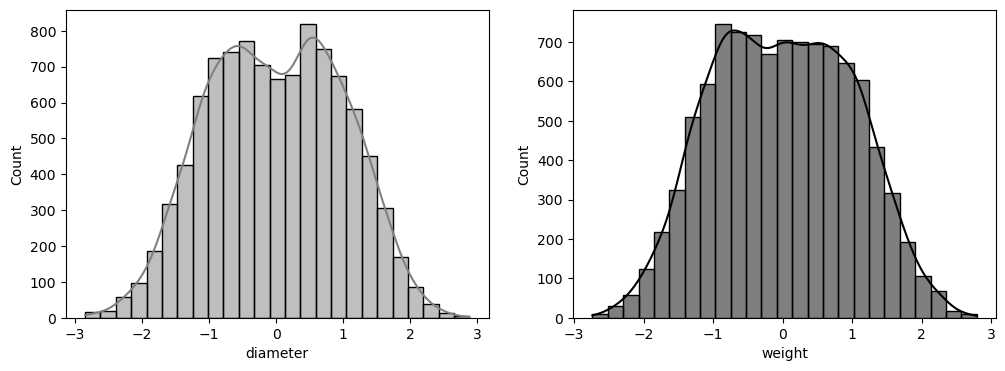

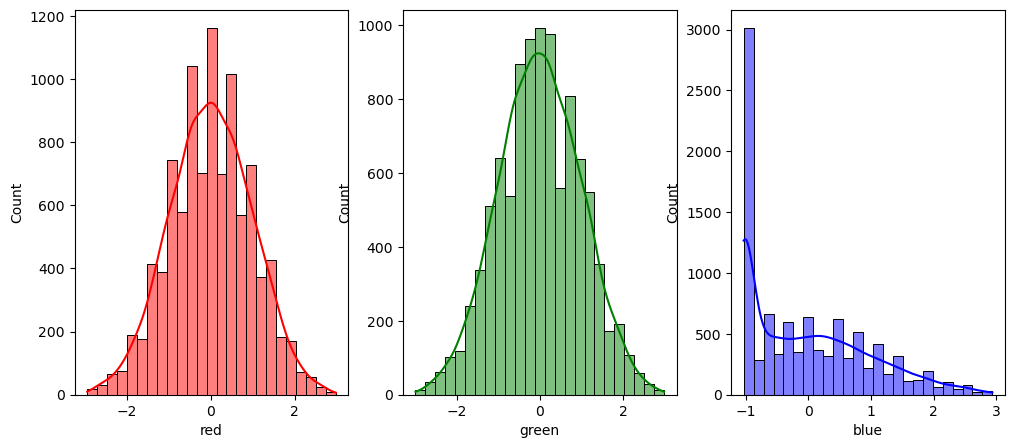

In [15]:
# distribution of data after standarization

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig, axs2 = plt.subplots(1, 3, figsize=(12, 5))

sns.histplot(data, x="diameter", kde=True, color='grey', ax=axs[0], bins = 25)
sns.histplot(data, x="weight", kde=True, color='black', ax=axs[1], bins = 25)
sns.histplot(data, x="red", kde=True, color='r', ax=axs2[0], bins = 25)
sns.histplot(data, x="green", kde=True, color='green', ax=axs2[1], bins = 25)
sns.histplot(data, x="blue", kde=True, color='b', ax=axs2[2], bins = 25)

## Calculate P(Y=y) for all possible y

In [16]:
def calculate_prior(data, Y):
    classes = sorted(list(data[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(data[data[Y]==i])/len(data))
    return prior

## Calculate P(X=x|Y=y) using Gaussian dist.

In [17]:
def calculate_likelihood_gaussian(data, feat_name, feat_val, Y, label):
    feat = list(data.columns)
    data = data[data[Y]==label]
    mean, std = data[feat_name].mean(), data[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [18]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test model

In [19]:
# y_pred = naive_bayes_gaussian(X_train, X_test, "name")

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# # Print the F1 score
# print("F1 Score:", f1_score(y_test, y_pred))


########## test model

# from sklearn.model_selection import train_test_split
# train, test = train_test_split(data, test_size=.2, random_state=41)

# X_test = test.iloc[:,:-1].values
# Y_test = test.iloc[:,-1].values
# Y_pred = naive_bayes_gaussian(train, X=X_test, Y="name")

# from sklearn.metrics import confusion_matrix, f1_score
# print(confusion_matrix(Y_test, Y_pred))
# print(f1_score(Y_test, Y_pred))